In [1]:
from __future__ import print_function
import os
import sys
sys.path.append('./scripts/')
import numpy as np
import xarray as xr
import pandas as pd

import warnings
warnings.simplefilter(action='ignore') #, category=FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import proplot as plot
plot.rc.reset()
plot.rc.update({"legend.handlelength": 2})
from mpl_toolkits.basemap import Basemap
import cmaps
import copy
import calendar
from scipy import interpolate

In [2]:
# =============== Import self-defined functions =============== #
# Read Isca dataset
from analysis_functions import (get_ds_arr_from_exps, sigma_to_pressure_level, add_datetime_info,
                                z_to_p, get_unique_line_labels, get_global_mean)

# Read observed dataset
from read_obs_CRE import read_toa_flux_obs, read_surf_flux_obs, read_toa_cre_obs

# Calculate CRE and CWP for Isca dataset
from isca_cre_cwp import calc_toa_cre_for_isca, calc_total_cwp_for_isca, add_toa_net_flux_to_ds_arr

# Function to produce table in LaTex format (Table 3)
from print_obs_isca_cf_flux_table import print_obs_isca_cf_flux_table

# Fig. 6 Function for zonal mean profiles of cloud fractions
from zonal_mean_cld_frac_vertical_profile import zonal_mean_cld_frac_vertical_profile

# Fig. 8 Function to plot the cloud amount seasonal cycle in polar region
# Fig. 16 Function to plot CRE seasonal cycle
from seasonal_cycle_plot import polar_cloud_amount_seasonal_cycle, cre_seasonal_cycle

# Figs. 7, 9, 10, 12, 14 Spatial patterns
from plot_spatial_figs import cmp_spatial_patterns_from_exps_and_obs

# Fig. 11 Low cloud improvement
from low_cld_scheme_improvement import low_cloud_improvement_evaluation

# Fig. 13 LW CRE evaluation
from bin_dataset_nd import bin_obs_data, bin_isca_exp_data
from lwcre_improvement_evaluation import cld_amt_and_lw_cre_composite_analysis_omega500

# Fig. 15 Zonal mean structure
from zonal_cre_from_cmip_isca import cmp_zonal_mean_CREs

# Fig. 17 Global mean CREs
from global_mean_CRE_bar_plot import global_mean_CRE_bar_plot

# Fig. 18, Taylor diagram
from taylor_stats import write_taylor_diagram_stats, plot_taylor_diagram

# Main function

In [3]:
# ================== Read Isca simulation datasets  ================== # 
P = os.path.join
l_title_add_gm = False
obs_base_dir = '/scratch/ql260/obs_datasets/'

fig_dir = './figs/'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

save_dt_dir = './data'
if not os.path.exists(save_dt_dir):
    os.mkdir(save_dt_dir)

exp_names = [ 'Linear_LS', 'Linear_FD', 'Linear_ALL',
            'Sundqvist_LS', 'Sundqvist_FD', 'Sundqvist_ALL']

exp_folder_names = [
    # linear
    'soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18',
    'soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18_adj_polar',
    'soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18_adj_polar_sc_park_ab_1.3_-0.1',
    # Sundqvist
    'soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18',
    'soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18_adj_polar',
    'soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18_adj_polar_sc',
    ]

# Read dataset array
print('Read dataset...')
start_file = 121
end_file = 240

# [None] will read default GFDL_DATA dir
base_dir_arr = [None] * 3 + ['/disco/share/ql260/data_isca/'] * 3 
start_file_arr = [start_file] * 6
end_file_arr = [end_file] * 6

file_nm = 'atmos_monthly_plev.nc'
ds_lev_arr = []
ds_lev_arr_linear = []
ds_lev_arr_sundq = []

for k, (exp_folder_name, b_dir, sfile, efile) in enumerate(zip(exp_folder_names, 
                                    base_dir_arr, start_file_arr, end_file_arr)):
    print(exp_folder_name, b_dir, sfile, efile)
    try:
        ds_lev_tmp = get_ds_arr_from_exps([exp_folder_name], sfile, efile, base_dir=b_dir, file_name=file_nm)
    except:
        print('Interp first...')
        # interp data first
        plevs = [100000, 95000, 90000, 85000, 80000, 75000, 70000, 65000, 60000, 55000,
                50000, 45000, 40000, 35000, 30000, 25000, 20000, 15000, 10000, 5000, 0]
        sigma_to_pressure_level(exp_folder_name, sfile, efile, p_levs=plevs, base_dir=b_dir)
        ds_lev_tmp = get_ds_arr_from_exps([exp_folder_name], sfile, efile, base_dir=b_dir, file_name=file_nm)

    if k<3:
        ds_lev_arr_linear += ds_lev_tmp
    else:
        ds_lev_arr_sundq += ds_lev_tmp

ds_lev_arr = ds_lev_arr_linear + ds_lev_arr_sundq

for ds in ds_lev_arr:
    add_datetime_info(ds)

print('Calculate TOA CRE for dataset...')
calc_toa_cre_for_isca(ds_lev_arr)

print('Calculate cloud water path for dataset...')
calc_total_cwp_for_isca(ds_lev_arr)

print('Add Net TOA flux to dataset...')
add_toa_net_flux_to_ds_arr(ds_lev_arr)

Read dataset...
soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18 None 121 240
soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18_adj_polar None 121 240
soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18_adj_polar_sc_park_ab_1.3_-0.1 None 121 240
soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18 /disco/share/ql260/data_isca/ 121 240
soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18_adj_polar /disco/share/ql260/data_isca/ 121 240
soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18_adj_polar_sc /disco/share/ql260/data_isca/ 121 240
Calculate TOA CRE for dataset...
Calculate cloud water path for dataset...
Add Net TOA flux to dataset...


## Read observed datasets

In [4]:
# Read observed cloud radiative effect (CRE) and cloud water path (CWP)

obs_nm = 'CERES_EBAF Ed4.1'  #'CERES_EBAF Ed2.8'

print('Read surf flux from obs...')
obs_surf_flux_dict = list(read_surf_flux_obs(dataset_name=obs_nm).values())[0]
print('Read TOA flux from obs...')
obs_toa_flux_dict = list(read_toa_flux_obs (dataset_name=obs_nm).values())[0]
print('Read TOA CRE from obs...')
obs_toa_cre = read_toa_cre_obs()
#obs_toa_cre_dict = list(read_toa_cre_obs(dataset_name=obs_nm).values())[0]
obs_toa_cre_dict = obs_toa_cre[obs_nm]

obs_flux_dict = {**obs_toa_flux_dict, **obs_surf_flux_dict, **obs_toa_cre_dict}

print('Read CWP...')
# Get cloud water from CloudSat dataset
dt_dir = '/disca/share/ql260/CloudSat/ftp.cloudsat.cira.colostate.edu/2B-CWC-RO.P1_R05/cloudsat_cloud_water_path/data/'
fns = [P(dt_dir, 'cld_water_path_data_t42_' + str(year) + '.nc') for year in range(2012, 2017)]
cloudsat_ds = xr.open_mfdataset(fns, concat_dim='year')

var_names = ['lwp', 'iwp', 'cwp']
for var_nm in var_names:
    obs_flux_dict[var_nm] = cloudsat_ds[var_nm].mean('year') / 1e3

print('Read CRE/CWP dataset finished.')

Read surf flux from obs...
Read TOA flux from obs...
Read TOA CRE from obs...
Read CWP...
Read CRE/CWP dataset finished.


In [5]:
# Read cloud amount from ISCCP-H dataset

obs_cf_dict = {}

start_year = 2005 #1995
end_year = 2014

data_dir = P(obs_base_dir, 'isccp_data/ISCCP_H_series/ISCCP_H_basics/cldamt_t42')
files = [P(data_dir, 'ISCCP-Basic.HGM.v01r00.GLOBAL.%4d.%02d.99.9999.GPC.10KM.CS00.EA1.00_cldamt_t42.nc' % (year, month))
        for year in range(start_year, end_year+1) for month in range(1,13)]
ds_isccp = xr.open_mfdataset(files, decode_times=False, autoclose=True)

obs_cf_dict['tot_cld_amt'] = ds_isccp.cldamt

files = [P(data_dir, 'ISCCP-Basic.HGM.v01r00.GLOBAL.%4d.%02d.99.9999.GPC.10KM.CS00.EA1.00_cldamt_irtypes_t42.nc' % (year, month))
        for year in range(start_year, end_year+1) for month in range(1,13)]
ds_isccp = xr.open_mfdataset(files, decode_times=False, autoclose=True)

hml = ds_isccp.cldamt_irtypes

keys = ['low_cld_amt', 'mid_cld_amt', 'high_cld_amt']
for i, key in enumerate(keys):
    print('Read ISCCP ' + key)
    data_mean = hml[:,i,:,:]
    obs_cf_dict[key] = hml[:,i,:,:]

Read ISCCP low_cld_amt
Read ISCCP mid_cld_amt
Read ISCCP high_cld_amt


### Use CALIPSO-GOCCP Dataset for Cloud Fraction Comparison

In [6]:
def read_calipso(file_nm, start_year, end_year):
    ds_calipso = xr.open_dataset(file_nm, decode_times=False)
    add_datetime_info(ds_calipso)

    l_year = np.logical_and(ds_calipso.year>=start_year, ds_calipso.year<=end_year)
    ds_calipso = ds_calipso.where(l_year, drop=True) 
    try:
        ds_calipso = ds_calipso.rename_dims({'latitude':'lat', 'longitude':'lon'})
    except:
        pass

    obs_cf_dict = {}
    obs_cf_dict['tot_cld_amt'] = ds_calipso.cltcalipso * 1e2
    obs_cf_dict['low_cld_amt'] = ds_calipso.cllcalipso * 1e2
    obs_cf_dict['mid_cld_amt'] = ds_calipso.clmcalipso * 1e2
    obs_cf_dict['high_cld_amt'] = ds_calipso.clhcalipso * 1e2
    
    return obs_cf_dict

# =========== Read CALIPSO-GOCCP dataset =========== #
start_year = 2007
end_year = 2015
print('Read CALIPSO-GOCCP dataset', start_year, end_year)

data_dir = P(obs_base_dir, 'GOCCP_v3/2D_Maps')
file_nm = P(data_dir, 'MapLowMidHigh330m_200606-201910_avg_CFMIP2_sat_3.1.2.nc')
obs_cf_dict_calipso = read_calipso(file_nm, start_year, end_year)

file_nm = P(data_dir, 'MapLowMidHigh330m_200606-201910_avg_CFMIP2_sat_3.1.2_t42.nc')
obs_cf_dict_calipso_t42 = read_calipso(file_nm, start_year, end_year)

Read CALIPSO-GOCCP dataset 2007 2015


##  Table 3

In [7]:
# # Use the ISCCP-H dataset
# # print flux table
# file_name = P(save_dt_dir, 'properties_in_isca_obs_1bit.tex')
# tbl = print_obs_isca_cf_flux_table(ds_lev_arr, exp_names, obs_cf_dict, obs_flux_dict,
#                             file_name=file_name, float_fmt='%.1f')

In [8]:
# Use the CALIPSO-GOCCP dataset
# print flux table
file_name = P(save_dt_dir, 'properties_in_isca_obs_1bit_calipso.tex')
tbl = print_obs_isca_cf_flux_table(ds_lev_arr, exp_names, obs_cf_dict_calipso, obs_flux_dict,
                            file_name=file_name, float_fmt='%.1f')

In [9]:
tbl

Obs   Linear_LS   Linear_FD  Linear_ALL  \
Low cloud amount (%)      40.417149   54.568524   49.316188   48.649629   
Middle cloud amount (%)   20.316099   25.878947   20.755872   20.568637   
High cloud amount (%)     31.597884   42.330166   30.378469   30.367635   
Total cloud amount (%)    68.947211   75.570413   66.396392   65.977831   
TOA net SW flux          241.271240  226.809669  229.247814  229.592815   
TOA net LW flux          240.297943  220.383554  224.764580  224.866996   
TOA net flux               0.973288    6.426115    4.483234    4.725819   
TOA SW CRE               -45.782684  -58.794437  -56.305611  -55.969562   
TOA LW CRE                27.974928   36.399973   31.333361   31.029655   
TOA net CRE              -17.807758  -22.394463  -24.972251  -24.939910   
Cloud water path         119.308079  140.725959  124.886147  125.964438   

                         Sundqvist_LS  Sundqvist_FD  Sundqvist_ALL  
Low cloud amount (%)        53.771414     48.341022      47.456330  
Middle cloud amount (%)     25.348673     20.174707      20.025102  
High cloud amount (%)       35.937514     25.478856      25.485092  
Total cloud amount (%)      72.403555     63.323077      62.635427  
TOA net SW flux            228.692919    231.224979     231.479201  
TOA net LW flux            223.340722    227.594507     227.449700  
TOA net flux                 5.352197      3.630472       4.029501  
TOA SW CRE                 -56.879959    -54.315138     -54.055546  
TOA LW CRE                  33.344631     28.538615      28.302321  
TOA net CRE                -23.535326    -25.776524     -25.753226  
Cloud water path           137.507486    121.917283     122.221093

## Fig. 6 zonal mean profiles of cloud fractions

plot zonal mean cloud fraciton profile...


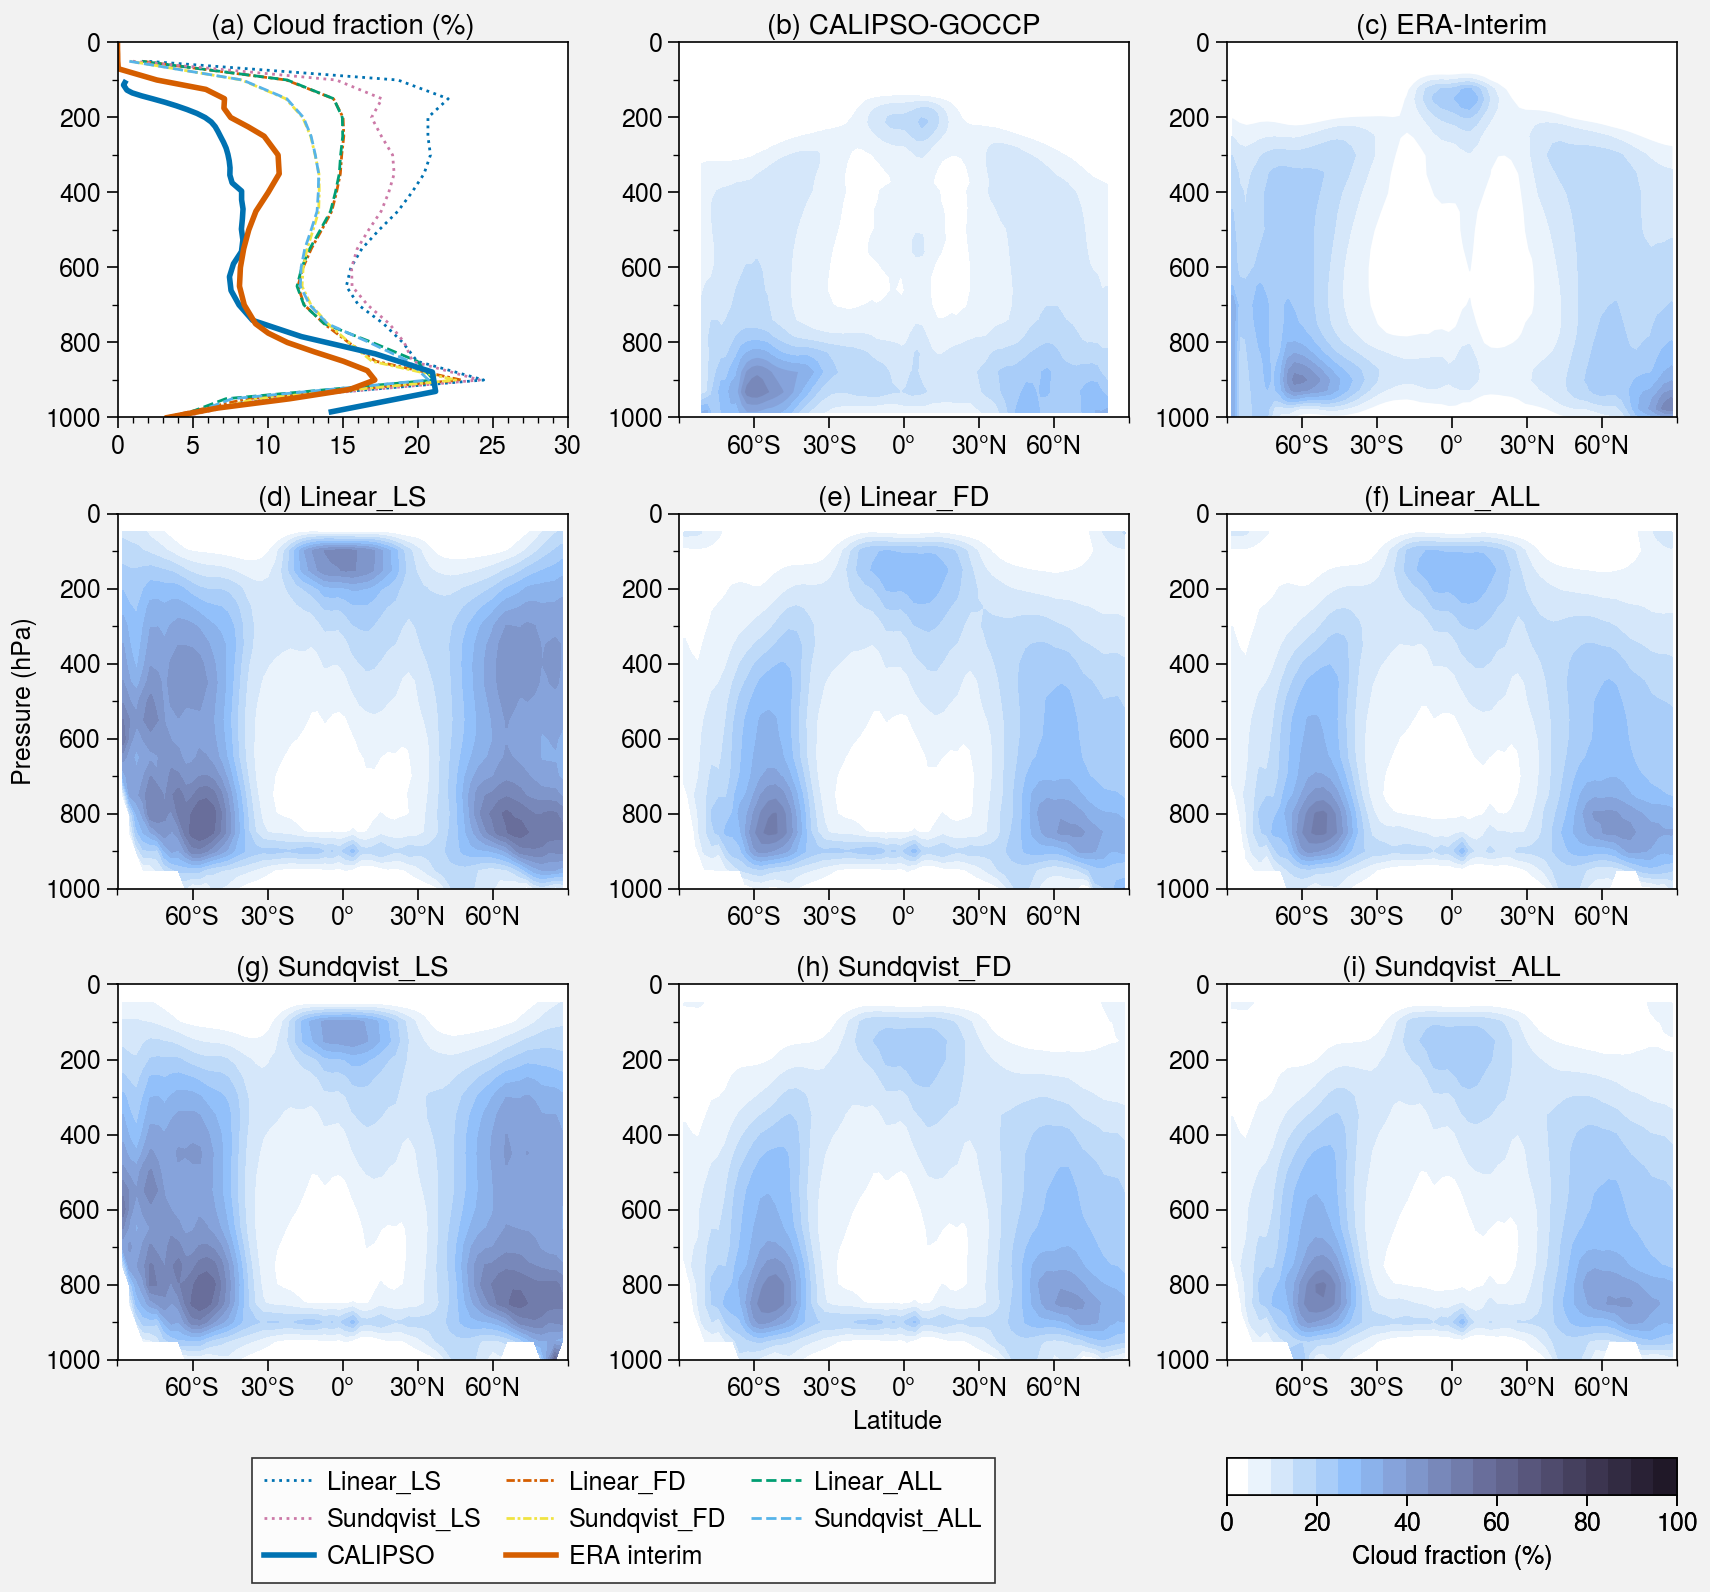

In [10]:
# ================== Fig. 6 zonal mean profiles of cloud fractions  ================== # 

# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html
line_styles = [':', (0, (3, 1, 1, 1)), '--', ':', (0, (3, 1, 1, 1)), '--']

# plot zonal mean cloud fraciton profile
print('plot zonal mean cloud fraciton profile...')
fig_name = P(fig_dir, 'cloud_zonal_mean_vert_profiles.pdf')
zonal_mean_cld_frac_vertical_profile(ds_lev_arr, exp_names, line_styles, figname=fig_name)

## Fig. 7 Geographical pattern of low cloud amount

In [11]:
# =============== Self-defined colormap  =============== #
bottom = cm.get_cmap('RdBu_r', 128)
top = cm.get_cmap('RdBu_r', 128)
newcolors = np.vstack((bottom(np.linspace(0.1, 0.5, 12)),
                    np.array([1.0, 1.0, 1.0, 1.0]),
                    top(np.linspace(0.5, 0.9, 12))))
BuWhRd = ListedColormap(newcolors, name='BuWhRd')

# =============== Self-defined colormap  =============== #
N = 11
a = cm.get_cmap(cmaps.CBR_wet, N)
b = np.ones((2*N-1, 4))
for i in range(N-1):
    b[2*i,:] = np.array(a(i))
    b[2*i+1,:] = (np.array(a(i)) + np.array(a(i+1))) / 2
b[-1,:] = np.array(a(N-1)) #a(N-1)
newcolors = np.vstack((b))
CBR_wet_21lev = ListedColormap(newcolors, name='CBR_wet_21lev')

Plot spatial patterns
low_cld_amt


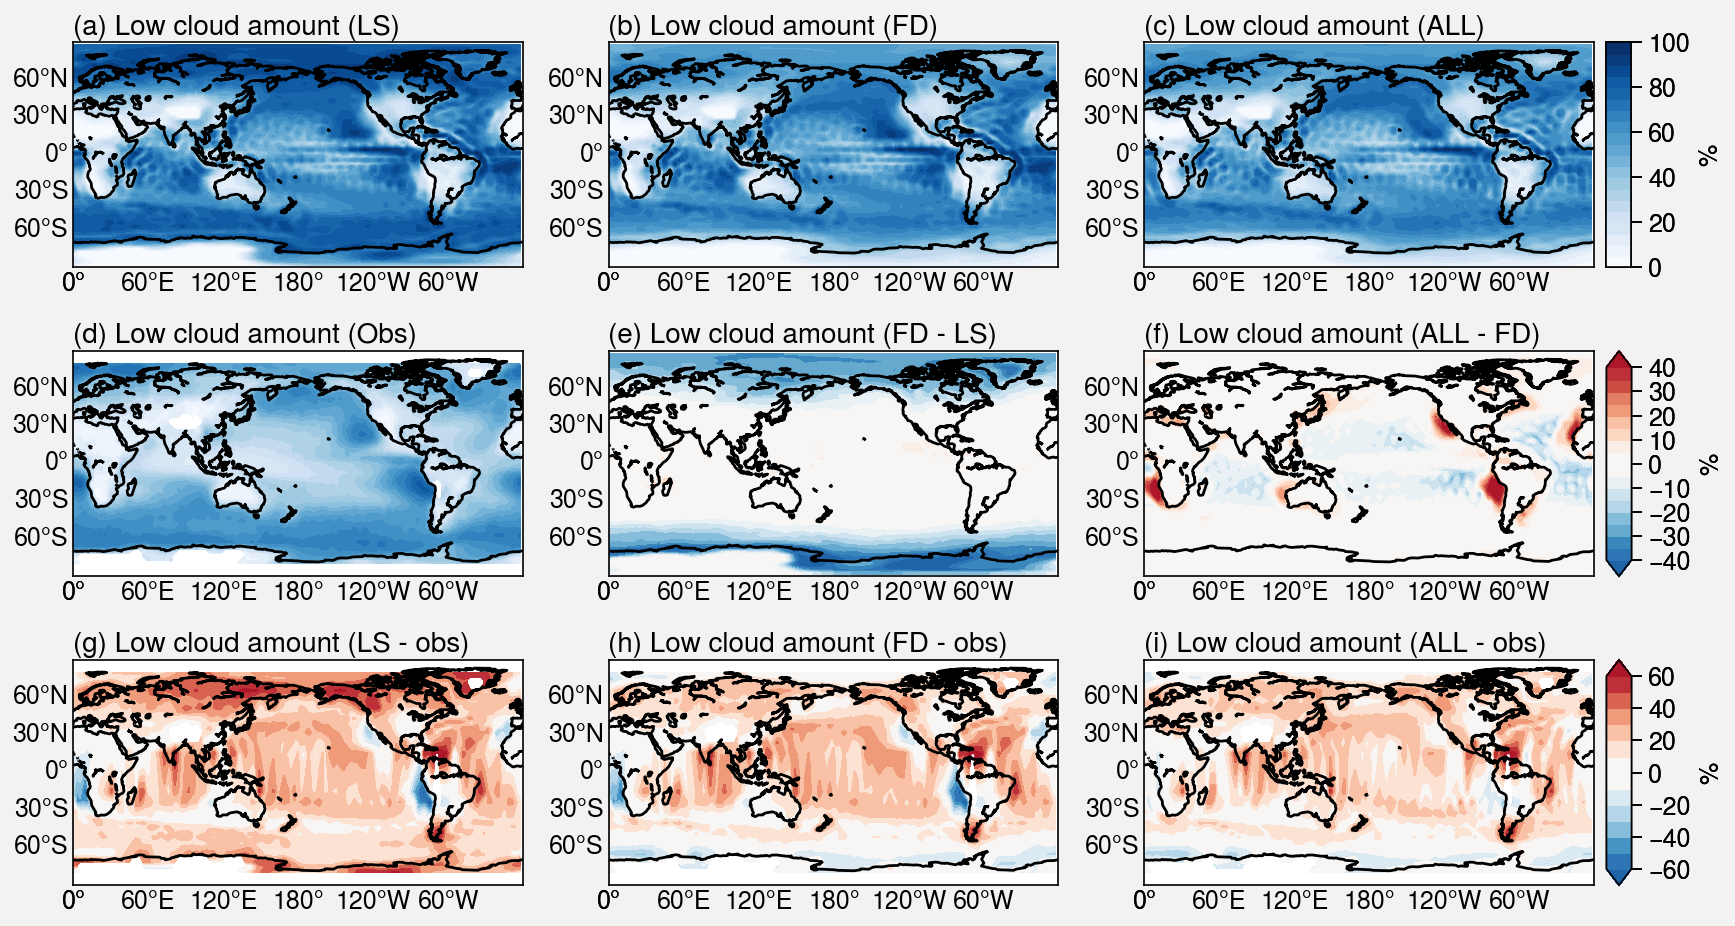

In [12]:
ds_arr_spatial = [ds_lev_arr[0], ds_lev_arr[1], ds_lev_arr[2]]
diff_colormap = BuWhRd       # cmaps.BlueWhiteOrangeRed # 'RdBu_r'
cld_cmap1 = cmaps.MPL_Blues  # CBR_wet_21lev #cmaps.CBR_wet #cmaps.precip_11lev # #cmaps.amwg # cmaps.MPL_Blues
l_title_add_gm = False

print('Plot spatial patterns')

'''
# cmp tot_cld_amt
var_name = 'tot_cld_amt'
print(var_name)
fig_name = P(fig_dir, 'tot_cld_amt_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_cf_dict, var_name, fig_name,
                obs_name='Obs', title_nm='Total cldamt', 
                cmap1=cld_cmap1, cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

# cmp high_cld_amt
var_name = 'high_cld_amt'
print(var_name)
fig_name = P(fig_dir, 'high_cld_amt_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_cf_dict, var_name, fig_name, 
                obs_name='Obs', title_nm='High cldamt', 
                cmap1=cld_cmap1, cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

# cmp mid_cld_amt
var_name = 'mid_cld_amt'
print(var_name)
fig_name = P(fig_dir, 'mid_cld_amt_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_cf_dict, var_name, fig_name, 
                obs_name='Obs', title_nm='Middle cldamt', 
                cmap1=cld_cmap1, cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)
                #cmap1=, cmap2=diff_colormap)
'''

# cmp low_cld_amt
var_name = 'low_cld_amt'
print(var_name)
# fig_name = P(fig_dir, 'low_cld_amt_isca_obs.pdf')
# cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_cf_dict, var_name, fig_name, 
#                 obs_name='Obs', title_nm='Low cldamt',
#                 cmap1=cld_cmap1, cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)
# ======== Use CALIPSO-GOCCP dataset ========== #
fig_name = P(fig_dir, 'low_cld_amt_isca_obs_calipso.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_cf_dict_calipso_t42, var_name, fig_name, 
                obs_name='Obs', title_nm='Low cldamt',
                cmap1=cld_cmap1, cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

## Fig. 8 Cloud amount seasonal cycyle in Arctic region

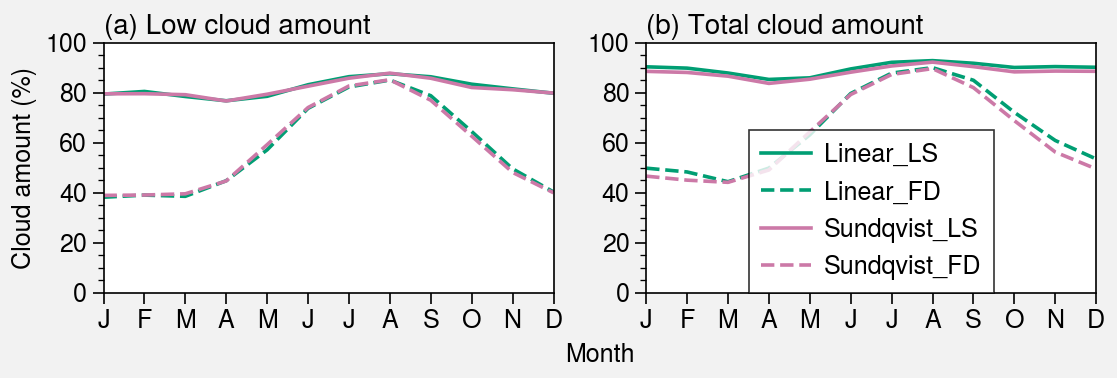

In [13]:
fig_name = P(fig_dir, 'cloud_amount_in_arctic_region.pdf')
# Linear_LS, Linear_FD, Sundqvist_LS, Sundqvist_FD
index = [0, 1, 3, 4]
ds_arr_local = [ds_lev_arr[i] for i in index]
exp_names_local = [exp_names[i] for i in index]
#line_styles_local = [line_styles[i] for i in index]
polar_cloud_amount_seasonal_cycle(ds_arr_local, exp_names_local, fig_name) # obs_cf_dict,

## Fig. 9 CWP

cwp


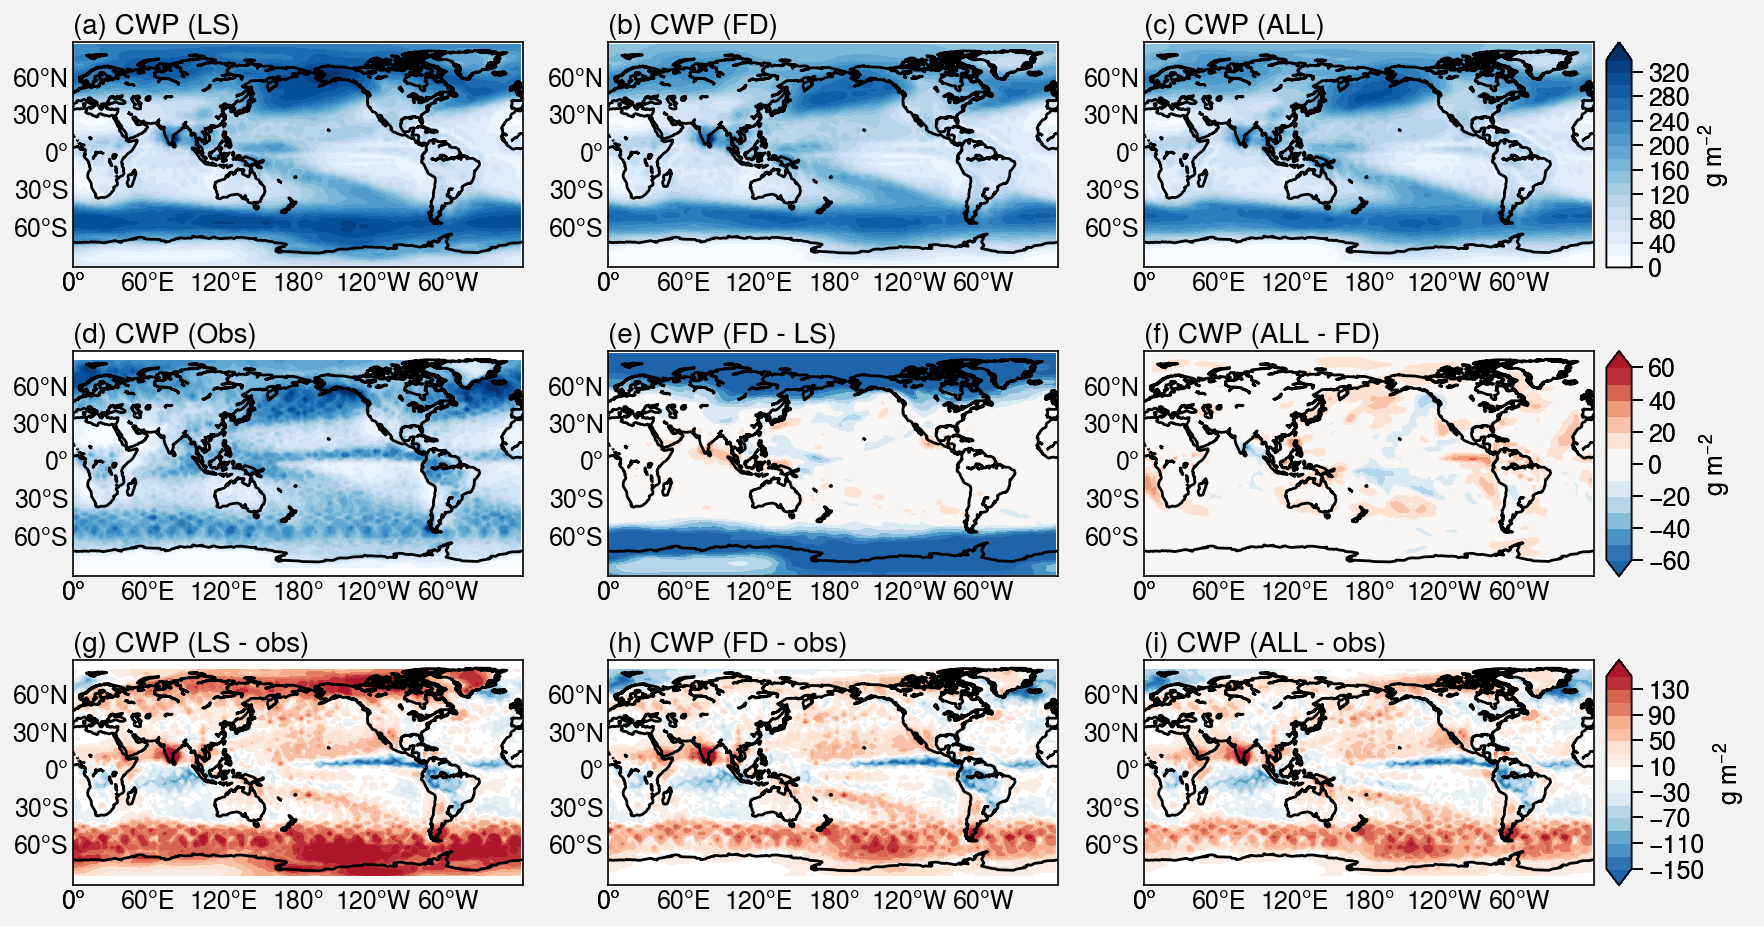

In [14]:
# Cloud water path
var_name = 'cwp'
print(var_name)
fig_name = P(fig_dir, 'cwp_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='CWP', 
                cmap1='Blues', cmap2=diff_colormap, coeff=1.0e3, l_title_add_gm=l_title_add_gm)

## Fig. 10 SW CRE

toa_sw_cre


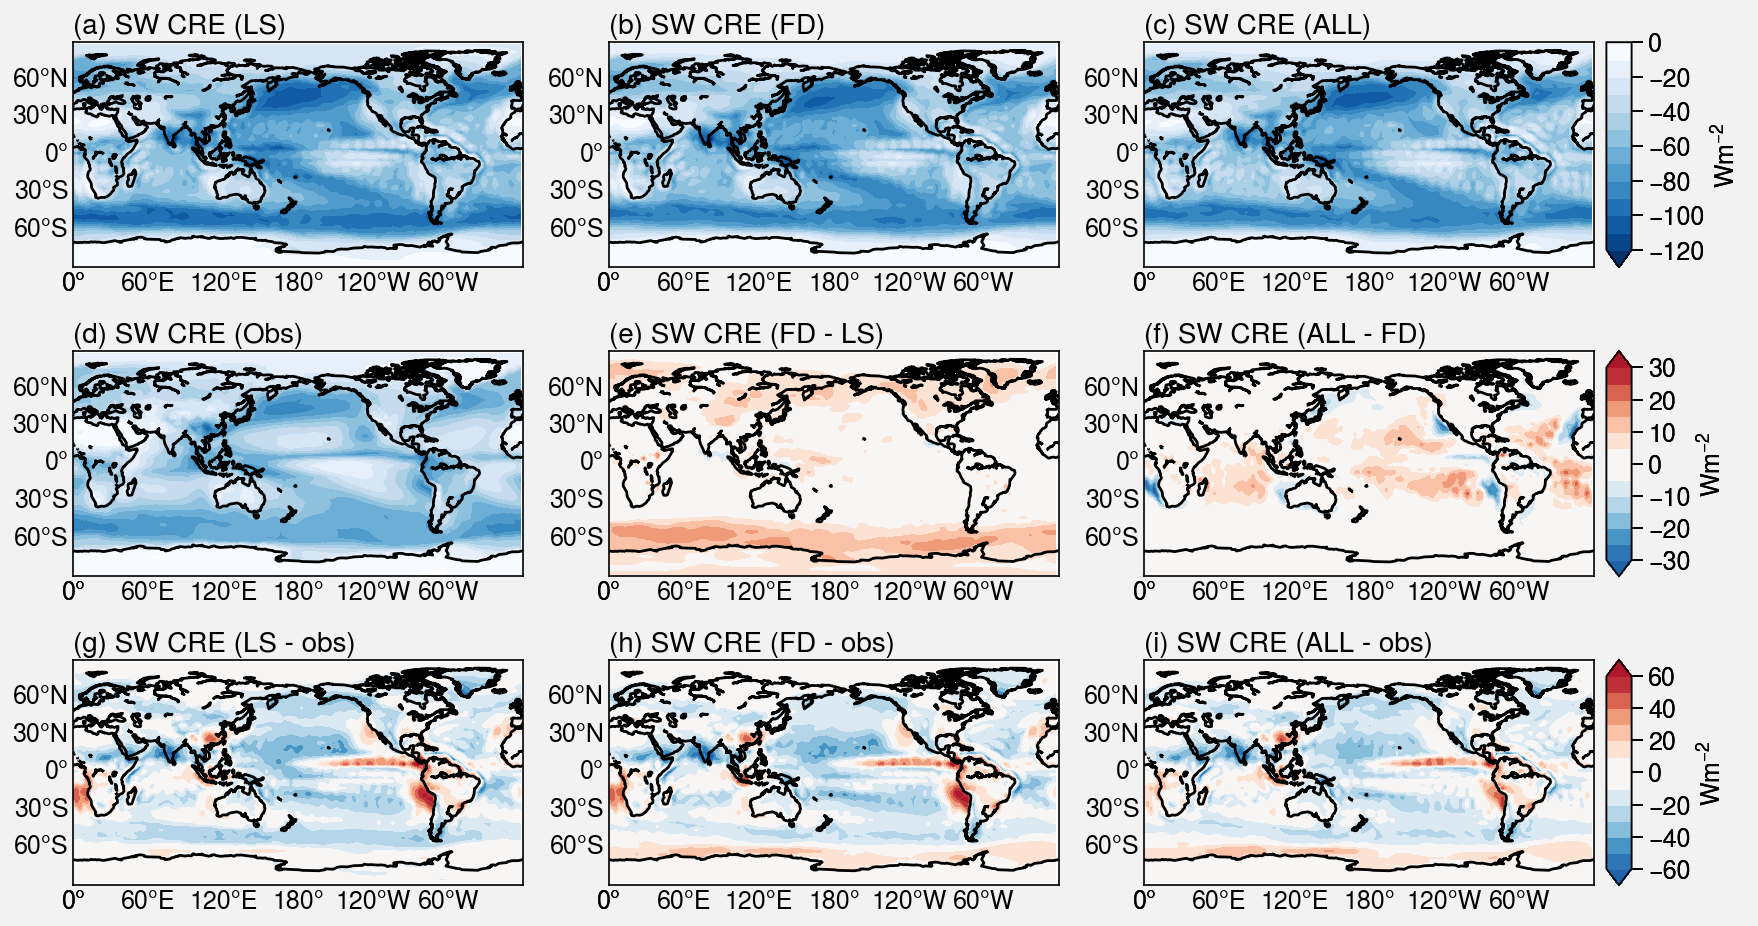

In [15]:
## ======== Flux  ======== ##
'''
# cmp reflected SW flux
var_name = 'toa_sw_up'
print(var_name)
fig_name = P(fig_dir, 'toa_sw_up_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='Reflected SW', 
                cmap1='Oranges', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

# cmp OLR
var_name = 'olr'
fig_name = P(fig_dir, 'toa_olr_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='OLR', 
                cmap1='Oranges', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

# cmp net flux
var_name = 'toa_net_flux'
print(var_name)
fig_name = P(fig_dir, 'toa_net_flux_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='Net flux', 
                cmap1='RdBu_r', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)
'''

## ======== CRE  ======== ##
var_name = 'toa_sw_cre'
print(var_name)
fig_name = P(fig_dir, 'toa_sw_cre_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='SW CRE', 
                cmap1='Blues_r', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

## Fig. 11  Low cloud improvement

Low cloud improvement evaluation...


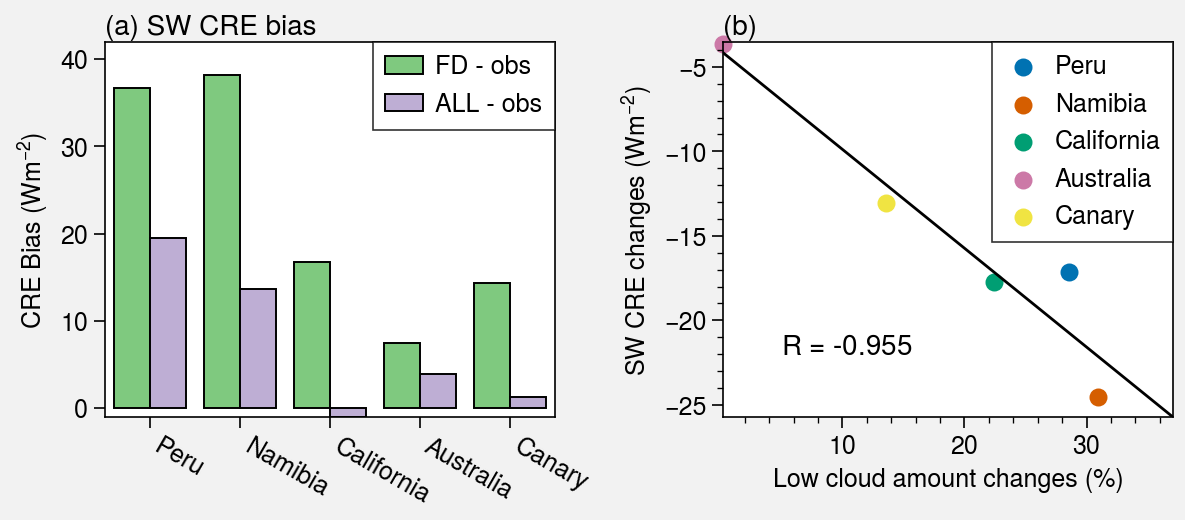

In [16]:
print('Low cloud improvement evaluation...')
ds_arr_low = [ds_lev_arr_linear[1], ds_lev_arr_linear[2]]
exp_names_local = [exp_names[1], exp_names[2]]

fig_name = P(fig_dir, 'SW_CREs_improvement_linear.pdf')
low_cloud_improvement_evaluation(ds_arr_low, exp_names_local, obs_flux_dict, fig_name)

## Fig. 12 LW CRE

toa_lw_cre


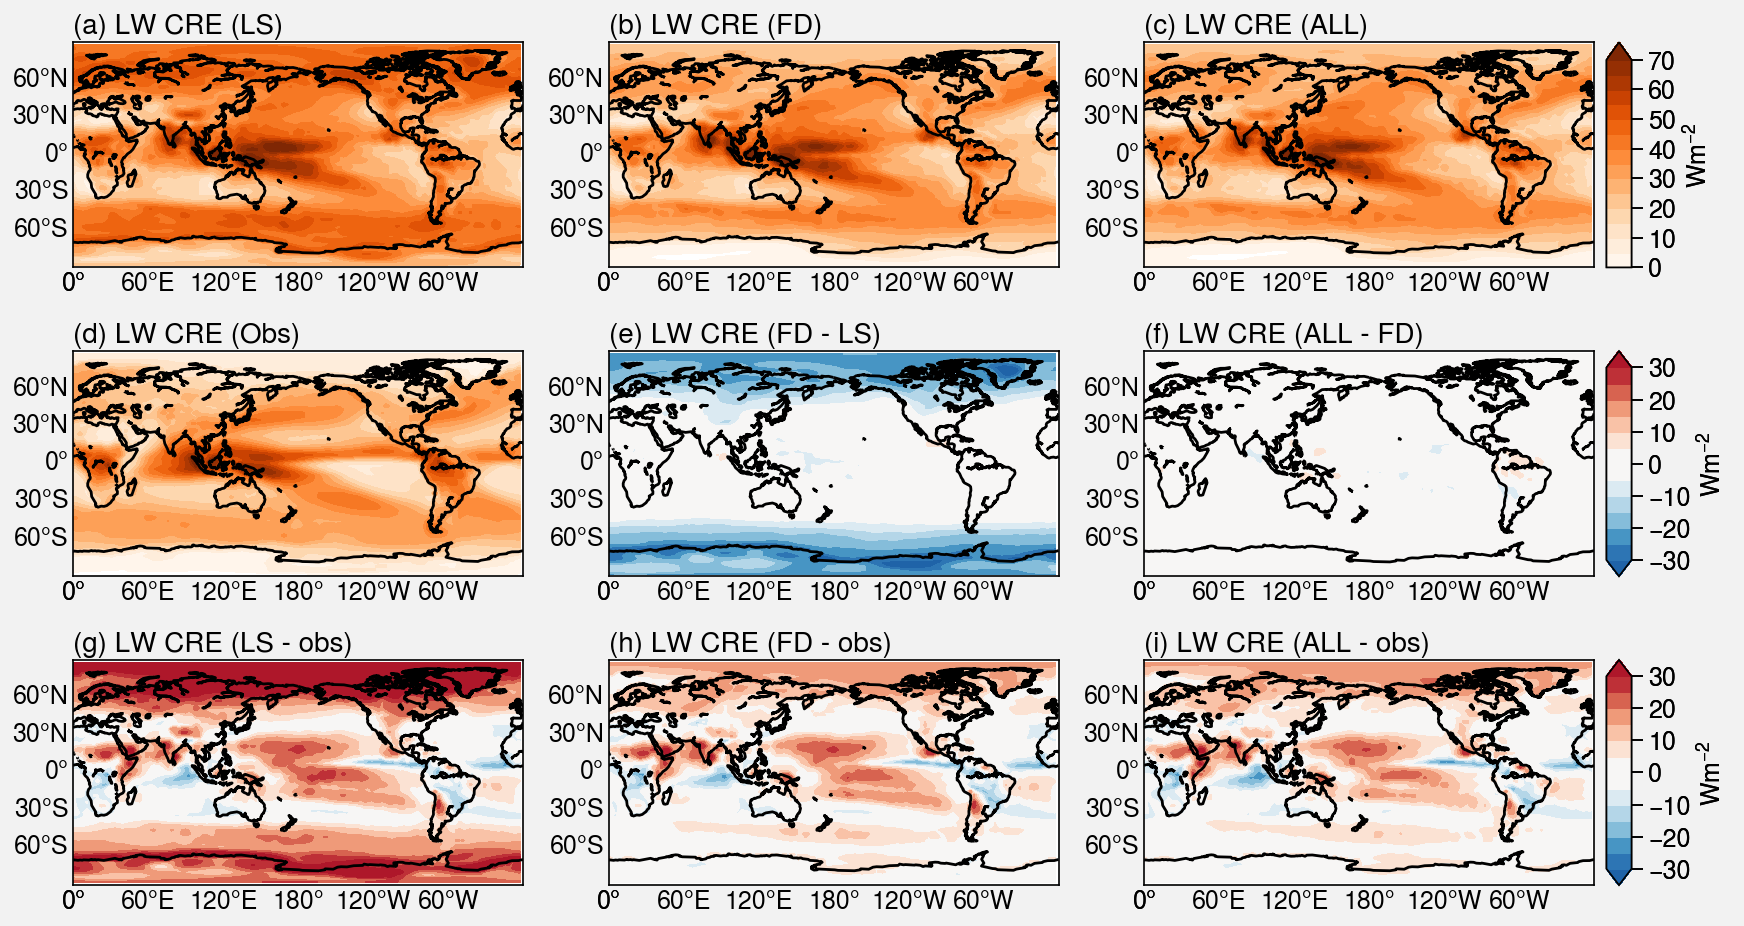

In [17]:
var_name = 'toa_lw_cre'
print(var_name)
fig_name = P(fig_dir, 'toa_lw_cre_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='LW CRE', 
                cmap1='Oranges', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

## Fig. 13 LW CRE improvement

In [18]:
# ======== bin dataset according to omega500 =========== #

ds_lev_arr_local = [x for x in ds_lev_arr_linear]
exp_names_local = [x for x in exp_names[0:3]]
land_sea_mask = 'ocean'
grp_time = 'year'
s_lat = -30
n_lat = 30

# omega500 bins
bin_nm = 'omega500'
bins = np.arange(-100, 101, 5)

print('bin data according to ' + bin_nm + '...')

# =========================== Observation ============================= #
# start_year = 2005
# end_year = 2014

# ============ Read ERAI omega data ============ #
print('Vertical velocity omega from ERAI...')
fnm_omega = P(obs_base_dir, 'ecmwf_data', 'ecmwf_omega_1979_2017_t42.nc')
ds_w = xr.open_dataset(fnm_omega, decode_times=False)
add_datetime_info(ds_w)
l_yr = np.logical_and(ds_w.year>=start_year, ds_w.year<=end_year)
omega = ds_w.w.where(l_yr, drop=True)   # Pa/s

omega_coeff = 3600. * 24. / 100.
omega500 = omega.sel(level=500) * omega_coeff

lats = omega500.lat
lons = omega500.lon
times = omega500.time

# ================== CRE ================== #
print('CRE data from CERES_EBAF...')
file_nm = 'CERES_EBAF-TOA_Ed4.1_Subset_200101-201812_t42.nc'
ds_cre = xr.open_dataset(P(obs_base_dir, 'CERES', file_nm), decode_times=False)
add_datetime_info(ds_cre)

l_yr_cre = np.logical_and(ds_cre.year>=start_year, ds_cre.year<=end_year)
cre_dt = {}
cre_dt['toa_sw_cre'] = (ds_cre.toa_sw_clr_c_mon - ds_cre.toa_sw_all_mon).where(l_yr_cre, drop=True)
cre_dt['toa_lw_cre'] = (ds_cre.toa_lw_clr_c_mon - ds_cre.toa_lw_all_mon).where(l_yr_cre, drop=True)
cre_dt['toa_net_cre'] = cre_dt['toa_sw_cre'] + cre_dt['toa_lw_cre']

# construct the dataset
dims = ('time', 'lat', 'lon')
ds_obs = xr.Dataset({ 'omega500': (dims, np.array(omega500)), 
            'toa_sw_cre': (dims, np.array(cre_dt['toa_sw_cre'])),
            'toa_lw_cre': (dims, np.array(cre_dt['toa_lw_cre'])),
            'toa_net_cre': (dims,np.array(cre_dt['toa_net_cre'])),
            'low_cld_amt': (dims, np.array(obs_cf_dict_calipso_t42['low_cld_amt'])),
            'mid_cld_amt': (dims, np.array(obs_cf_dict_calipso_t42['mid_cld_amt'])),
            'high_cld_amt': (dims, np.array(obs_cf_dict_calipso_t42['high_cld_amt'])),
            'tot_cld_amt': (dims, np.array(obs_cf_dict_calipso_t42['tot_cld_amt']))},
            coords={'time': times, 'lat': omega500.lat, 'lon': lons})

add_datetime_info(ds_obs)

ds_bin = bin_obs_data(ds_obs, s_lat=s_lat, n_lat=n_lat, 
            grp_time_var=grp_time, bin_var_nm=bin_nm,
            bins=bins, land_sea=land_sea_mask)
# use filter to remove the empty string
# refer to: https://stackoverflow.com/questions/8626694/joining-multiple-strings-if-they-are-not-empty-in-python
dt_fn = '_'.join(filter(None, ['ds_obs_bin', bin_nm, grp_time, land_sea_mask]))
ds_bin.to_netcdf(P(save_dt_dir, dt_fn+'.nc'), mode='w', format='NETCDF3_CLASSIC')
print(dt_fn + '.nc saved.')

# =========================== Isca ============================= #
file_ids = [x for x in exp_names_local]
for ds, file_id in zip(ds_lev_arr_local, file_ids):
    ds_bin = bin_isca_exp_data(ds, s_lat=s_lat, n_lat=n_lat, 
                grp_time_var=grp_time, bin_var_nm=bin_nm, bin_var=None,
                bins=bins, land_sea=land_sea_mask)
    
    dt_fn = '_'.join(filter(None, ['ds_bin', bin_nm, file_id, grp_time, land_sea_mask]))
    ds_bin.to_netcdf(P(save_dt_dir, dt_fn+'.nc'), mode='w', format='NETCDF3_CLASSIC')
    print(dt_fn + '.nc saved.')

bin data according to omega500...
Vertical velocity omega from ERAI...
CRE data from CERES_EBAF...
ds_obs_bin_omega500_year_ocean.nc saved.
ds_bin_omega500_Linear_LS_year_ocean.nc saved.
ds_bin_omega500_Linear_FD_year_ocean.nc saved.
ds_bin_omega500_Linear_ALL_year_ocean.nc saved.


plot omega500...
plot lines...


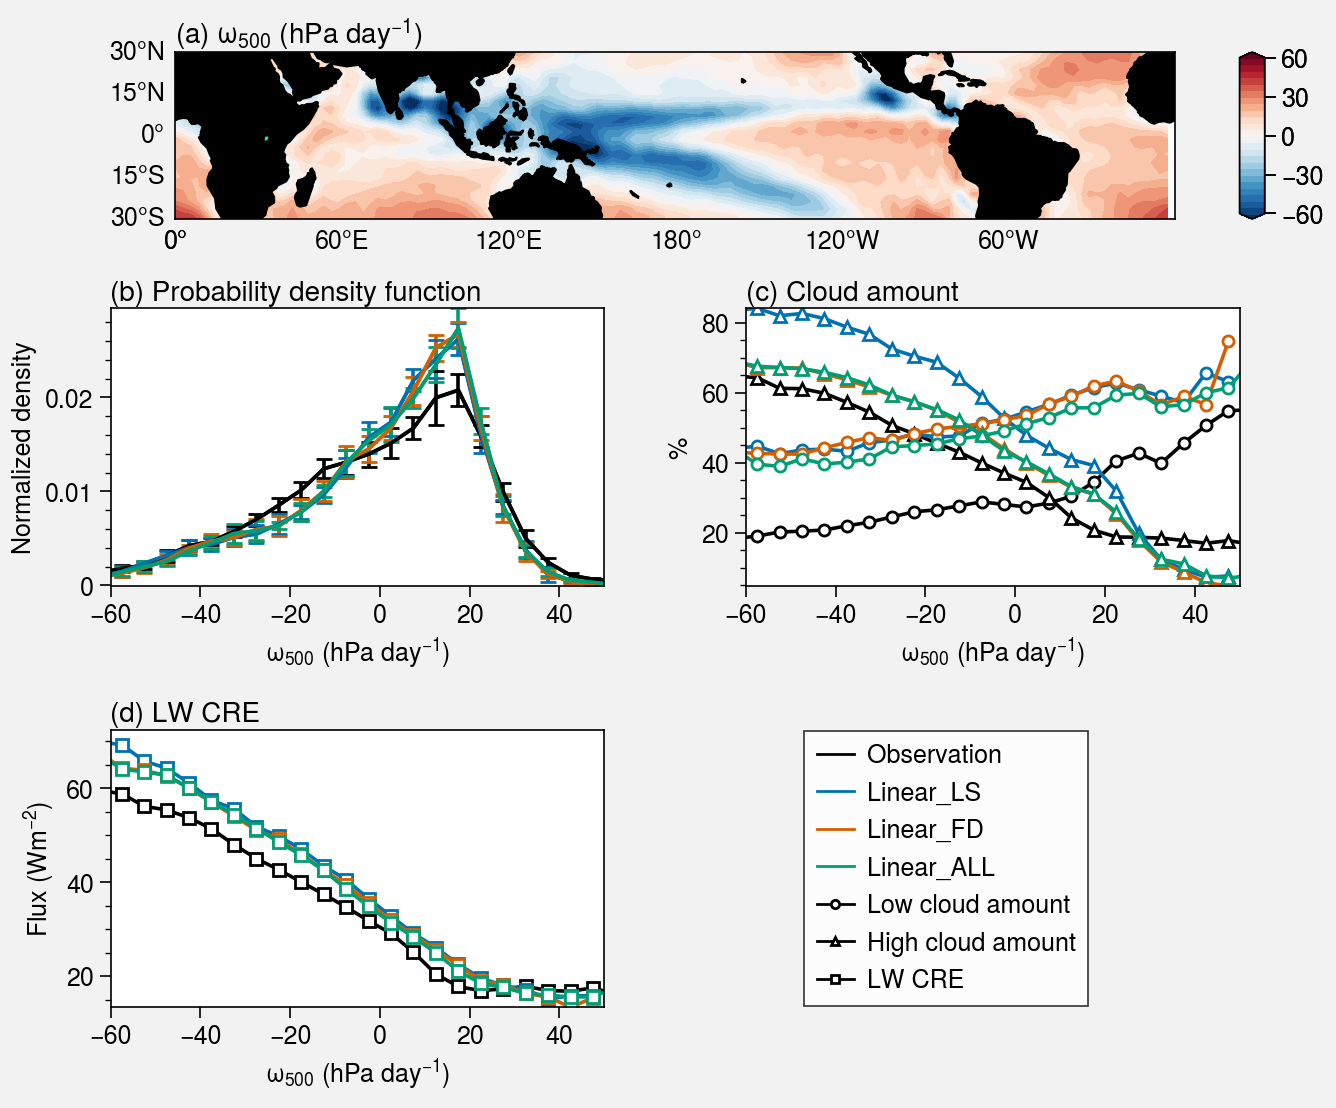

In [19]:
titles = ['Probability density function', 'Cloud amount', 'LW CRE']
ylabels = ['Normalized density', r'%', r'Flux (Wm$^{-2}$)']

dt_arrs = []
labels = ['Observation']

# produce obs bin data....
ds_bin = xr.open_dataset(P(save_dt_dir, 'ds_obs_bin_omega500_' + str(grp_time) + '_' 
                           + str(land_sea_mask)+'.nc'), decode_times=False)
dt_arr_obs = [ds_bin.pdf_omega, ds_bin.low_cld_amt, ds_bin.high_cld_amt, ds_bin.toa_lw_cre]
dt_arrs.append(dt_arr_obs)

# ================= ISCA data =============== #
for exp_nm in exp_names_local:
    ds_bin = xr.open_dataset(P(save_dt_dir, 'ds_bin_omega500_' + exp_nm + '_' + str(grp_time) + '_' 
                               + str(land_sea_mask) + '.nc'), decode_times=False)
    dt_arr_isca = [ds_bin.pdf_omega, ds_bin.low_cld_amt, ds_bin.high_cld_amt, ds_bin.toa_lw_cre]
    dt_arrs.append(dt_arr_isca)
    labels.append(exp_nm)

i_colors = ['k', 'C0', 'C1', 'C2']

fig_name = P(fig_dir, 'linear_cldamt_lwcre_binned_by_omega_' + grp_time + '_' + str(land_sea_mask) + '.pdf')
cld_amt_and_lw_cre_composite_analysis_omega500(ds_lev_arr_linear[0], dt_arrs, labels, i_colors, titles, ylabels,
         fig_name, nrows=2, ncols=2, bins=bins, capsize=3)

## Fig. 14 Net CRE

toa_net_cre


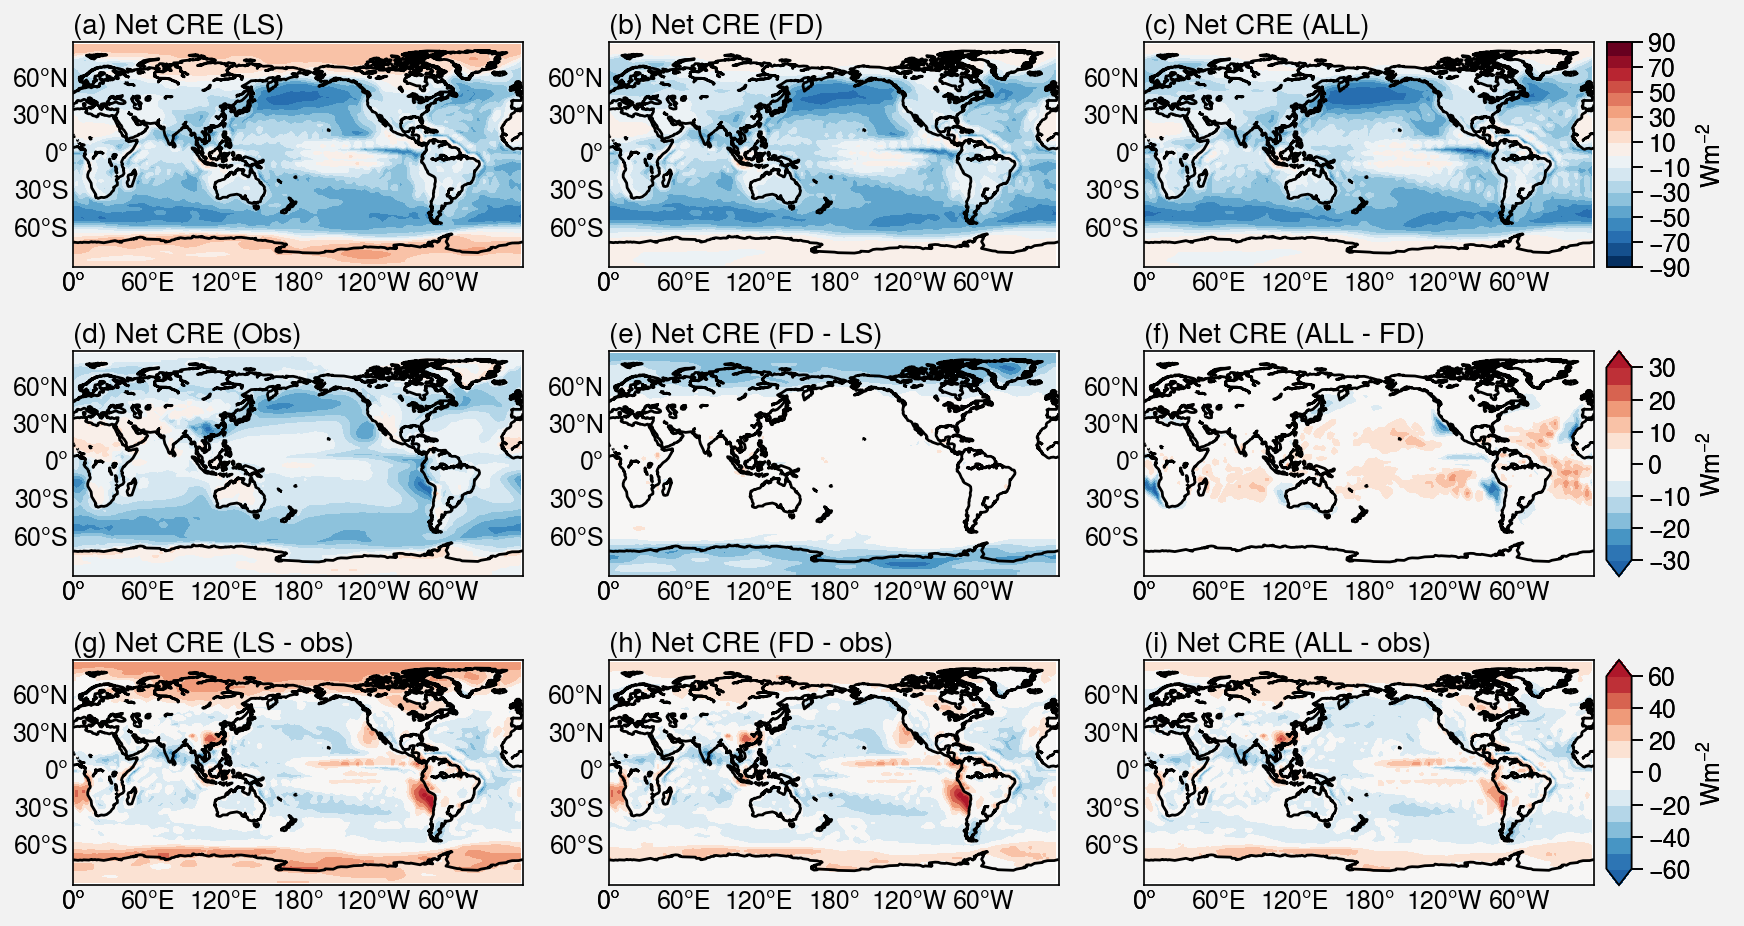

In [20]:
var_name = 'toa_net_cre'
print(var_name)
fig_name = P(fig_dir, 'toa_net_cre_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='Net CRE', 
                cmap1='RdBu_r', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

## Fig. 15 Zonal mean CREs

Read CRE from CMIP5 models...
Zonal mean TOA CRE analysis...


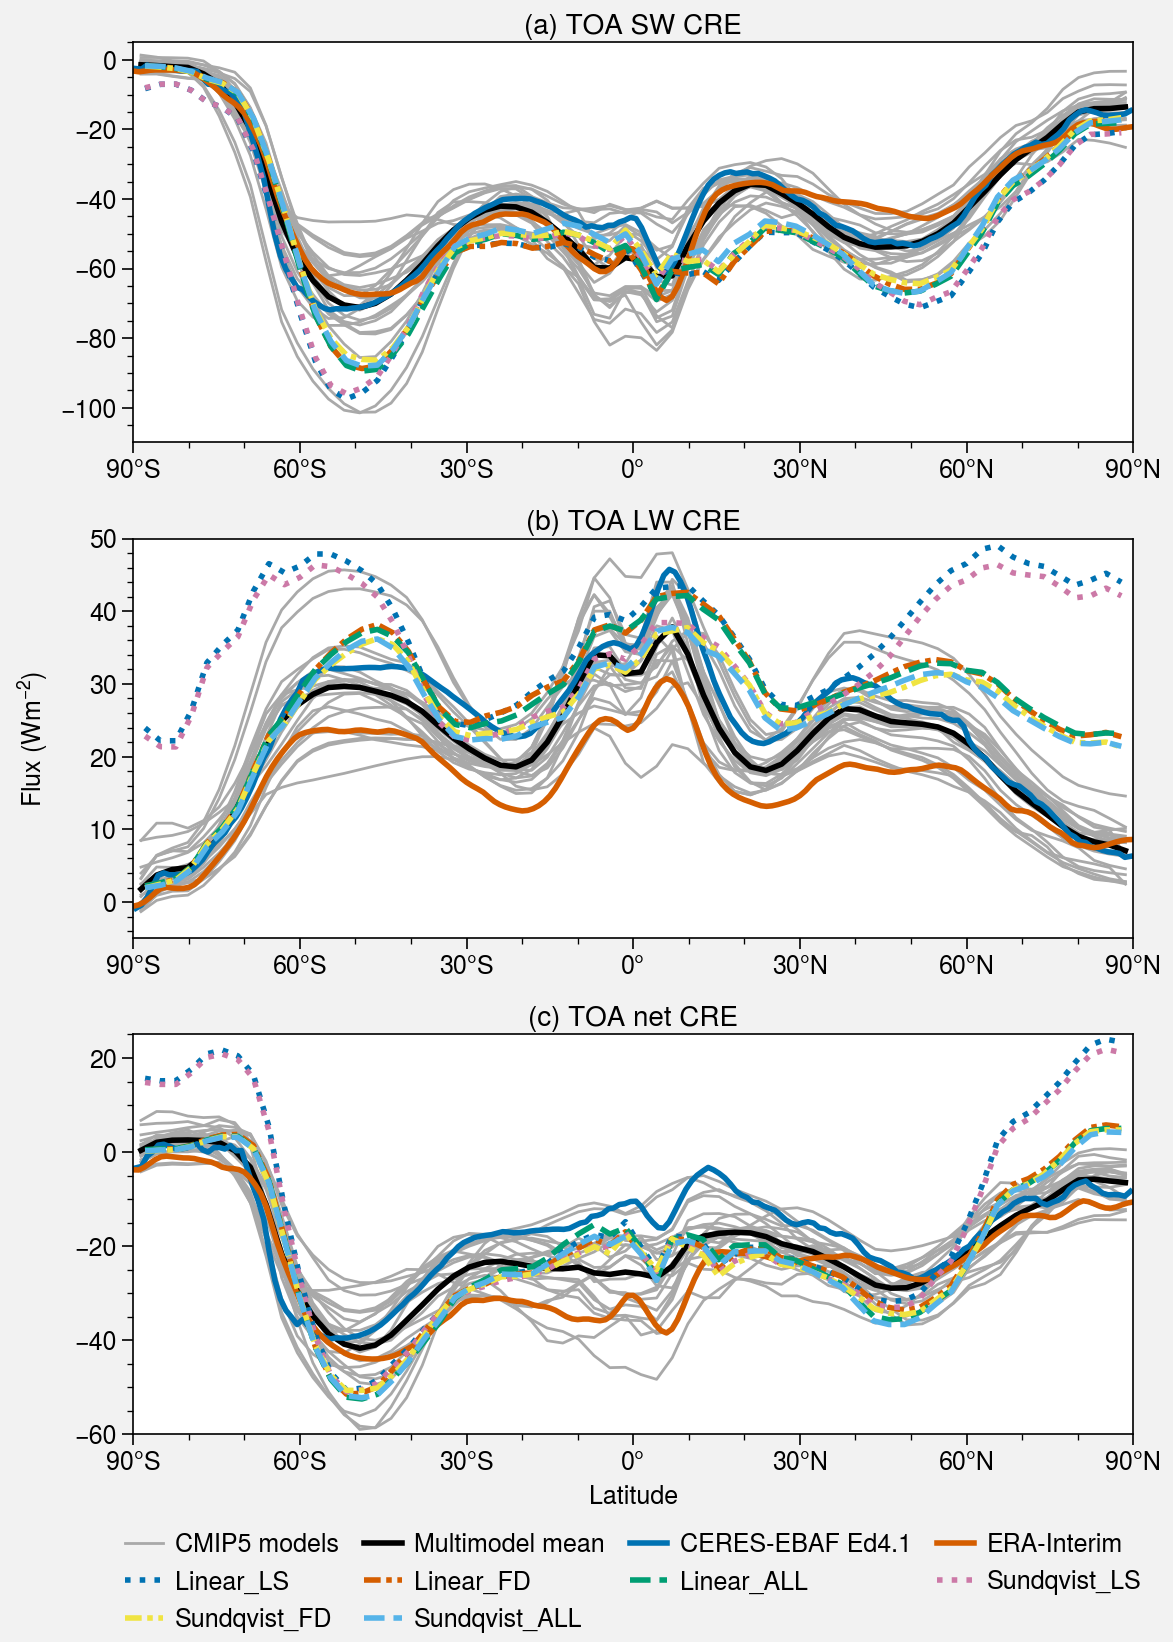

In [21]:
print('Read CRE from CMIP5 models...')
cmip5_zm_cre = np.load(P(save_dt_dir, 'cmip5_historical_zm_cre_r128x64.npy'), allow_pickle=True).item()

zonal_obs_names = [obs_nm, 'ERA-Interim']

print('Zonal mean TOA CRE analysis...')
fig_name = os.path.join(fig_dir, 'cmp_zonal_toa_CRE_cmip_isca.pdf')
cmp_zonal_mean_CREs(ds_lev_arr, exp_names, obs_toa_cre, fig_name, 
                cmip_dict=cmip5_zm_cre, line_styles=line_styles, obs_names=zonal_obs_names)

## Fig. 16  Seasonal cycle of CREs

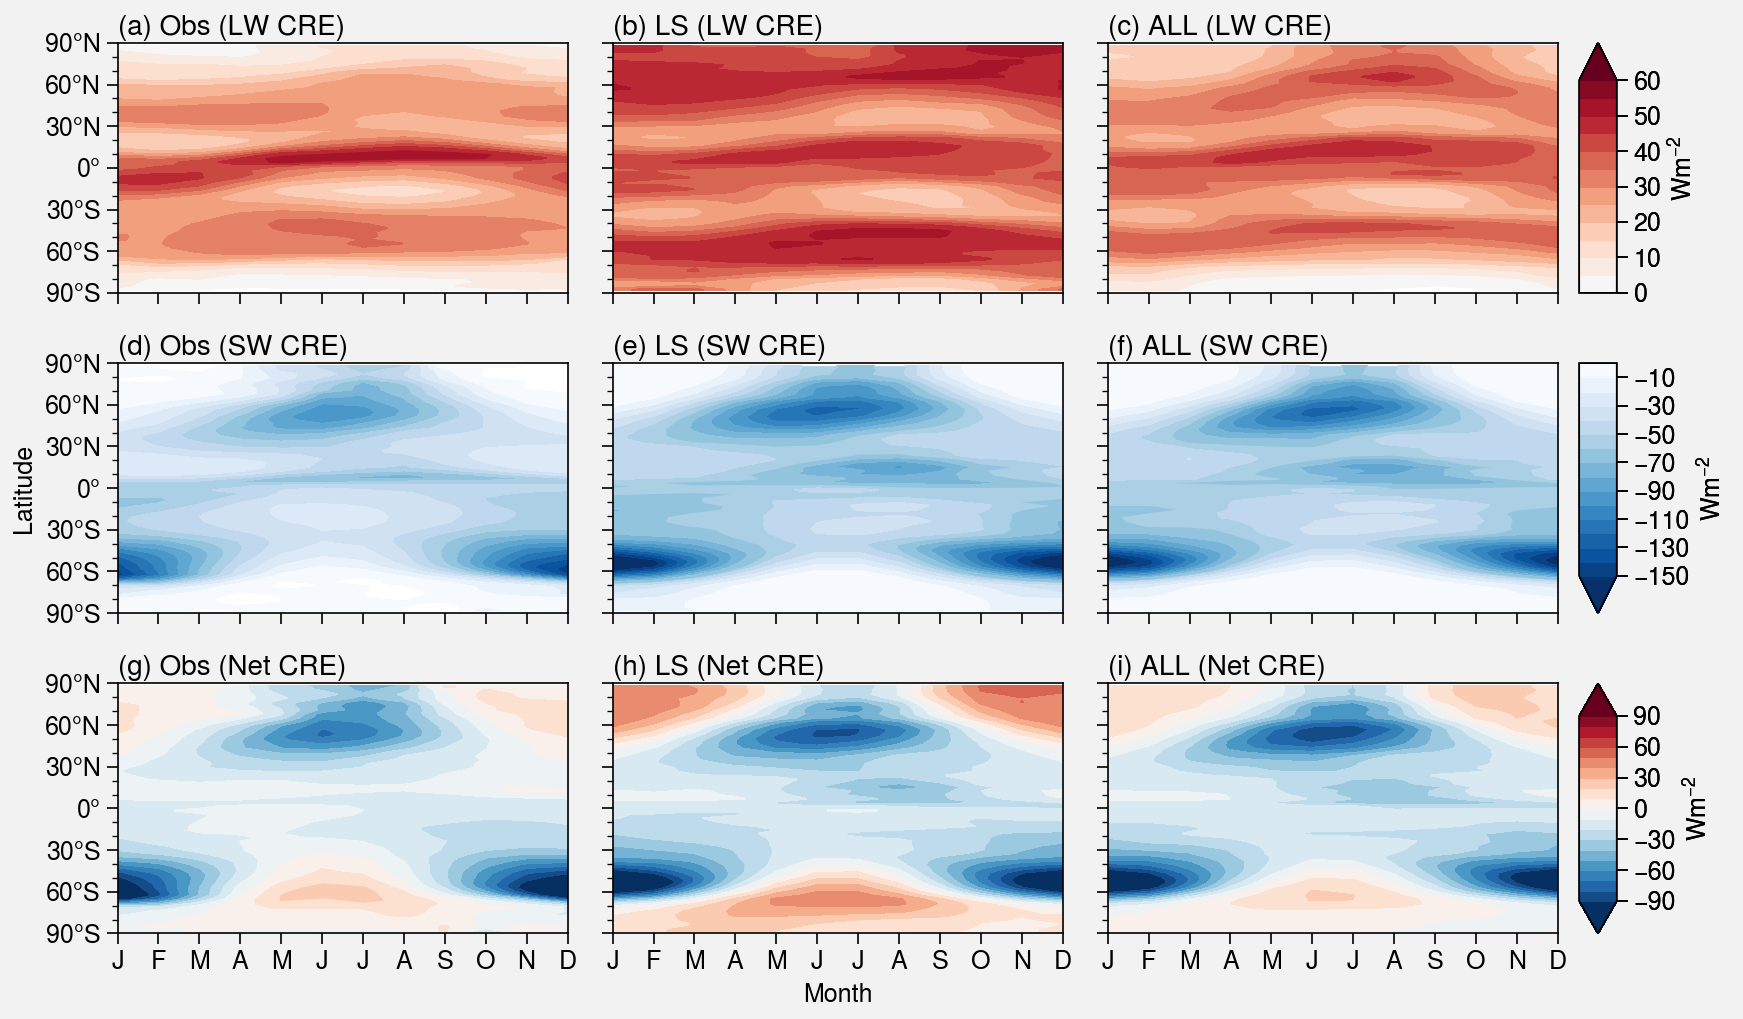

In [22]:
fig_name = P(fig_dir, 'isca_linear_amip_seasonal_cycle_map.pdf')
cre_seasonal_cycle(obs_flux_dict, [ds_lev_arr[0], ds_lev_arr[2]], ['LS', 'ALL'], fig_name)

## Fig. 17  Global mean bar plot

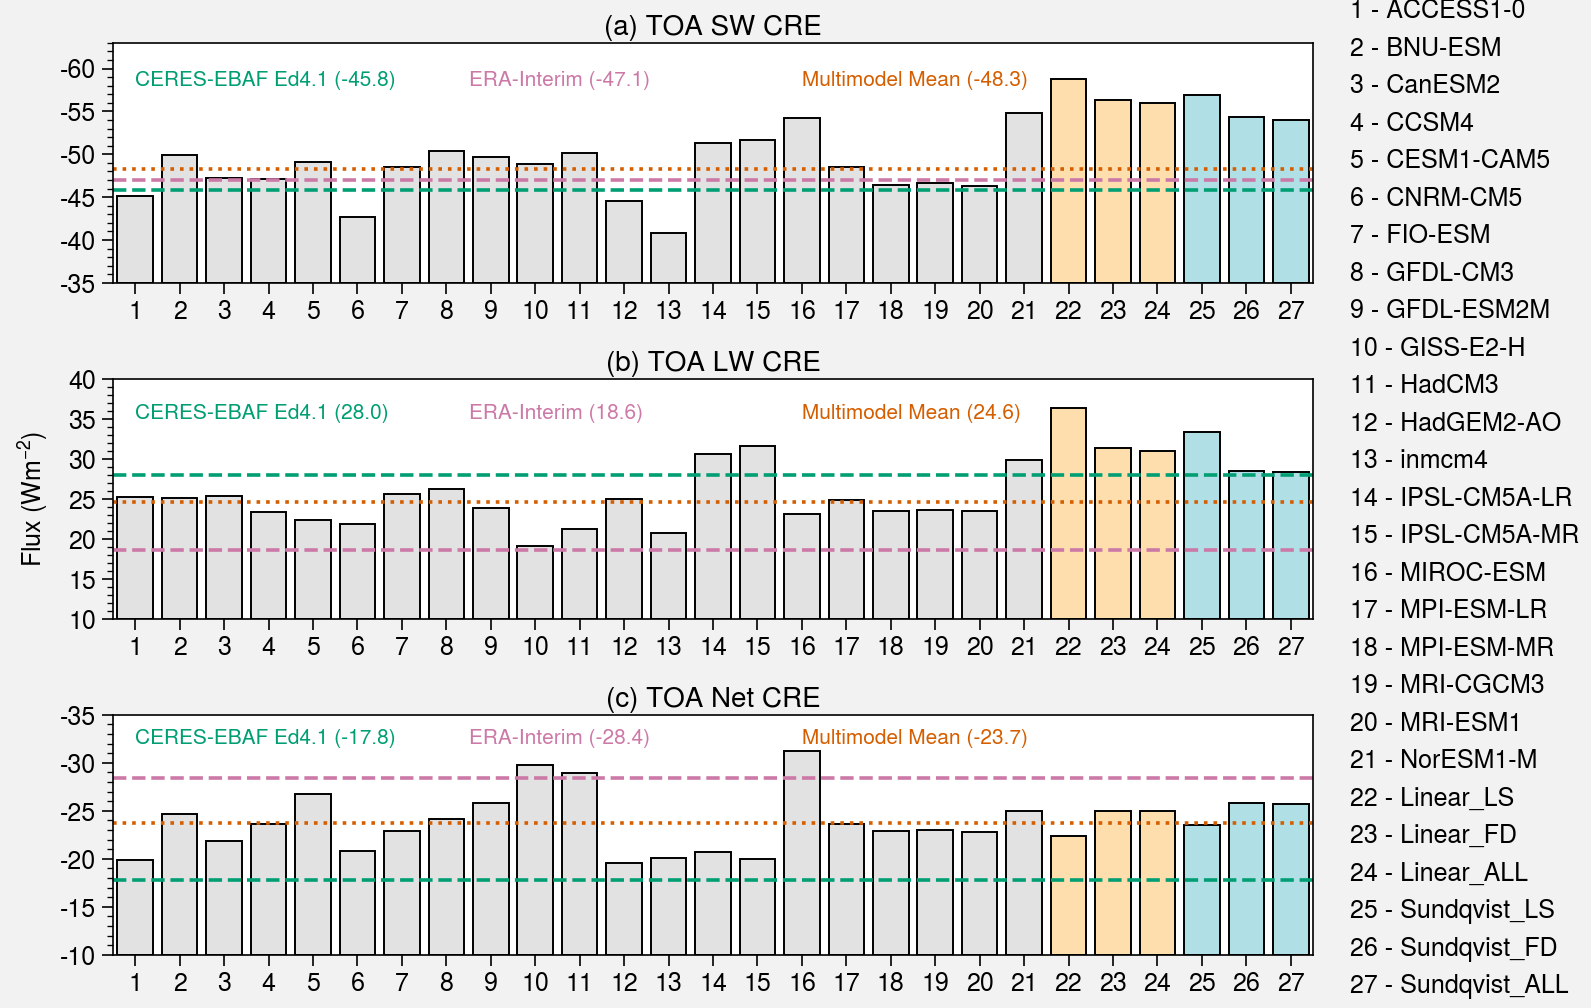

In [23]:
fig_name = P(fig_dir, 'global_mean_toa_CREs_4.1.pdf')
global_mean_CRE_bar_plot(ds_lev_arr, exp_names, obs_toa_cre, fig_name)

## Fig. 18  Taylor diagram

In [ ]:
taylor_dir = './data/taylor_data'
if not os.path.exists(taylor_dir):
    os.makedirs(taylor_dir)

lwcre_taylor_fn = P(taylor_dir, 'taylor_cmip5_isca_lwcre.txt')
swcre_taylor_fn = P(taylor_dir, 'taylor_cmip5_isca_swcre.txt')
netcre_taylor_fn = P(taylor_dir, 'taylor_cmip5_isca_netcre.txt')

write_taylor_diagram_stats(ds_lev_arr, exp_names, obs_flux_dict,
                            out_lwcre_fn=lwcre_taylor_fn,
                            out_swcre_fn=swcre_taylor_fn, 
                            out_netcre_fn=netcre_taylor_fn)

# plot taylor diagram
print('plot taylor diagram...')
fig_name = os.path.join(fig_dir, 'cmp_cmip5_isca_CRE_taylor_obs_v4.1_sundqvist_linear.pdf')
plot_taylor_diagram(lwcre_taylor_fn, swcre_taylor_fn, netcre_taylor_fn, figname=fig_name)

./data/taylor_data/taylor_cmip5_isca_lwcre.txt saved.
./data/taylor_data/taylor_cmip5_isca_swcre.txt saved.
./data/taylor_data/taylor_cmip5_isca_netcre.txt saved.
plot taylor diagram...
